# Tile experiments

In [5]:
from tile_class import TileOperations
from classifier import predict

In [ ]:
tiles_dir = '/home/bota/Downloads/projtiles1/'
gps_csv = '/home/bota/Desktop/active_sensing/src/gpstiles.csv'
raw_imgs_dir = "/media/bota/BOTA/wheat/APPEZZAMENTO_PICCOLO/"

# Initialize TileOperations
tile_ops = TileOperations(tiles_dir, gps_csv, raw_imgs_dir)


# Test finding the closest image
tile_to_test = (20, 20)
closest_image_path, minimum_distance = tile_ops.find_closest_image(tile_to_test)


# raw

print(f"Selected tile image: {closest_image_path}")
print(f"Distance to tile center: {minimum_distance:.2f}")
# """

Selected tile image: DJI_20240607121633_0156_D_point19_tile20_20_crop.png
Distance to tile center: 8.44


In [20]:
predictions = {}
for row in range(3, 113, 1):
    for col in range(13, 73, 1):
        tile_to_test = (row, col)
        raw_imgs = tile_ops.get_rawimagepath(tile_to_test)
        predictions_ = []

        for raw_img in raw_imgs:
            full_path = tiles_dir+raw_img
            predictions_.extend(predict(full_path))
        predictions[tile_to_test] = predictions_



In [22]:
predictions[(13,13)]

[0, 0]

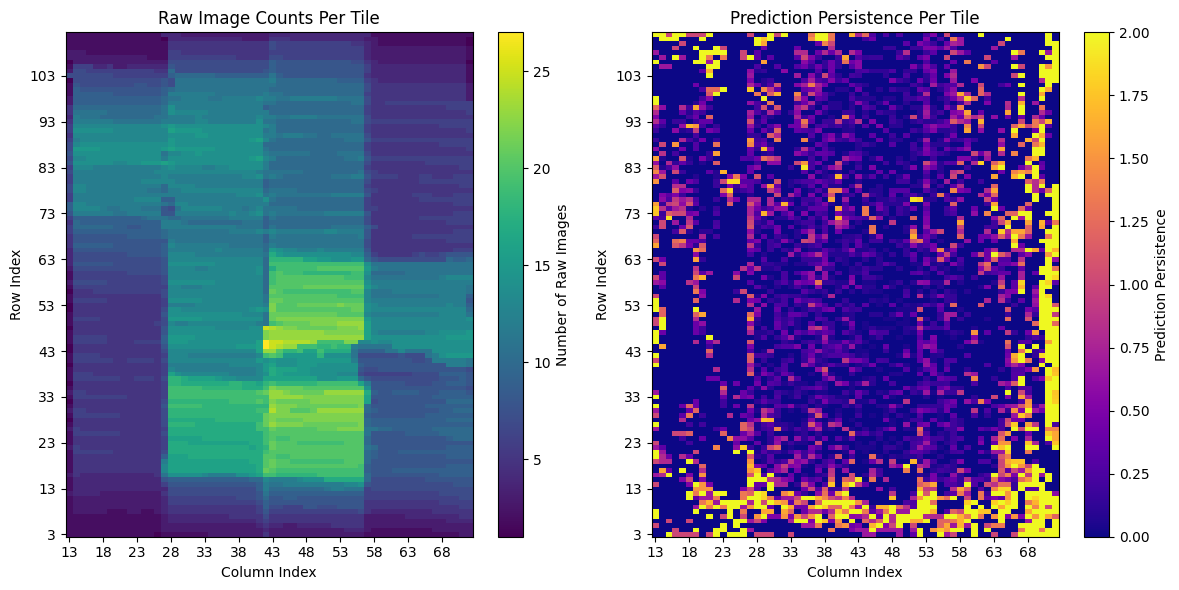

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize the data
rows = range(3, 113)
cols = range(13, 73)
raw_img_counts = np.zeros((len(rows), len(cols)))
persistence = np.zeros((len(rows), len(cols)))

# Populate the raw_img_counts and persistence arrays
for (row, col), preds in predictions.items():
    row_idx = row - 3
    col_idx = col - 13
    raw_img_counts[row_idx, col_idx] = len(preds)
    if preds:  # Avoid division by zero
        persistence[row_idx, col_idx] = sum(preds) / len(preds)

# Plot 1: Raw image counts per tile
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(raw_img_counts, aspect='auto', cmap='viridis', origin='lower')
plt.colorbar(label='Number of Raw Images')
plt.title('Raw Image Counts Per Tile')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

# Plot 2: Prediction persistence per tile
plt.subplot(1, 2, 2)
plt.imshow(persistence, aspect='auto', cmap='plasma', origin='lower')
plt.colorbar(label='Prediction Persistence')
plt.title('Prediction Persistence Per Tile')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.xticks(ticks=np.arange(0, len(cols), 5), labels=np.arange(13, 73, 5))
plt.yticks(ticks=np.arange(0, len(rows), 10), labels=np.arange(3, 113, 10))

# Show the plots
plt.tight_layout()
plt.show()
